## Harshal Dupare | 18MA20015 

colab view link : https://drive.google.com/file/d/18N-e40dtzWdWH0NTAXEm0mn8mHEg_p_U/view?usp=sharing

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [ ]:
import numpy as np
from time import time
import torch
import torch.nn as nn
import torch.functional as F
import cv2
from matplotlib import pyplot as plt
from torchvision import transforms,datasets
from torch import nn, optim
from tqdm.notebook import tqdm

## ConvNN

2. Build a convolution neural network with given description (LeNet model). (only feed forward part, no backpropagation)
    * Convolution layer 1: 5*5, with 6 output channels
    * MaxPool1: 2*2, stride=2
    * Convolution layer 2: 5*5, with 16 output channels
    * MaxPool1: 2*2, stride=2
    * Linear Layer1: input (calculate yourself based on conv and pooling layer), output=120
    * Linear Layer2: input = 120, output=84
    * Linear Layer1: input=84, output=10
    * Use ReLU as activation function in each convolution and linear layer
    * Input: MNIST data (28*28)

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        
        self.conv1 = nn.Conv2d(1,6,5)
        self.maxpool1 = nn.MaxPool2d((2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(6,16,5)
        
        self.fcon1 = nn.Linear(256,120)
        self.fcon2 = nn.Linear(120,84)
        self.fcon3 = nn.Linear(84,10)
        
        self.relu = nn.ReLU()
        self.relu = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        
        x = self.conv1(x)      # [6,(28-5)/1+1,(28-5)/1+1] = [6,24,24]
        x = self.relu(x)
        x = self.maxpool1(x)   # [6,(24-2)/2+1,(24-2)/2+1] = [6,12,12]
        
        x = self.conv2(x)      # [16,(12-5)/1+1,(12-5)/1+1] = [16,8,8]
        x = self.relu(x)
        x = self.maxpool1(x)   # [16,(8-2)/2+1,(8-2)/2+1] = [16,4,4]
        
        x = x.view(-1,16*4*4)
        x = self.fcon1(x)
        x = self.relu(x)
        x = self.fcon2(x)
        x = self.relu(x)
        x = self.fcon3(x)
        
        # probs
        x = self.softmax(x)
        return x

In [ ]:
class Pipeline:
  def __init__(self,Model):
    self.model = Model()
    self.LR_decay = False
    self.lr_from = 1e-1
    self.lr_to = 1e-3

  def load_data(self,batch_size=256,image_size=28):
    self.batch_size = batch_size
    transform_data = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])

    try:
      train_data = datasets.MNIST(root='./data',train=True,download=False,transform = transform_data)
    except:
      train_data = datasets.MNIST(root='./data',train=True,download=True,transform = transform_data)
    trainloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=4)

    test_data = datasets.MNIST(root='./data',train=False,download=False,transform = transform_data)
    testloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=4)

    return trainloader,testloader

  def train(self,Trainloader,Testloader,Criterion,Optimizer,N_epoch=50,print_epoch_details=True):
    # training the model

    if self.LR_decay:
      lr_decay_step = (self.lr_from - self.lr_to)/(N_epoch)
    else:
      lr_decay_step = 0.0

    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in tqdm(range(N_epoch)):
        epoch_loss = 0.0
        correct_count = 0
        sample_count = 0
        Optimizer.zero_grad()
        i = 0
        # on Traning Data
        for (X_i,y_i) in Trainloader:
            if using_gpu:
                X_i,y_i=X_i.cuda(),y_i.cuda()
            
            output=self.model(X_i)
            
            y_i_pred = torch.argmax(output,dim=1)
            
            loss = Criterion(output,y_i)
            
            epoch_loss+=loss
            
            correct_count +=torch.sum(y_i==y_i_pred)
            sample_count+=len(y_i)
            i+=1

        tepoch_loss = 0.0
        tcorrect_count = 0
        tsample_count = 0
        ti = 0
        
        # on Testing Data
        for (tX_i,ty_i) in Testloader:
            if using_gpu:
                tX_i,ty_i=tX_i.cuda(),ty_i.cuda()
            
            toutput=self.model(tX_i)
            
            ty_i_pred = torch.argmax(toutput,dim=1)
            
            tloss = Criterion(toutput,ty_i)
            
            tepoch_loss+=tloss
            
            tcorrect_count +=torch.sum(ty_i==ty_i_pred)
            tsample_count+=len(ty_i)
            ti+=1

        epoch_loss=epoch_loss/(i)
        tepoch_loss=tepoch_loss/(ti)
        
        epoch_loss.backward()
        
        Optimizer.step()
        
        if self.LR_decay:
          for param_group in Optimizer.param_groups:
            param_group['lr'] = param_group['lr']-lr_decay_step
        
        train_loss.append(epoch_loss.item())
        train_acc.append(100*correct_count.item()/sample_count)
        test_loss.append(tepoch_loss.item())
        test_acc.append(100*tcorrect_count.item()/tsample_count)
        if print_epoch_details:
          print(f'Epoch {epoch+1:.0f}/{N_epoch:.0f} : Training loss: {train_loss[-1]:.4f} | Training Accuracy: {train_acc[-1]:.2f} | Testing loss: {test_loss[-1]:.4f} | Testing Accuracy: {test_acc[-1]:.2f} ')
    
    fig = plt.figure(figsize=[20,8]) 
    plt.subplot(121)
    plt.plot(range(N_epoch),train_loss,'g-',label='Training Loss') 
    plt.plot(range(N_epoch),test_loss,'r-',label='Testing Loss') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.subplot(122)
    plt.plot(range(N_epoch),train_acc,'g-',label='Training Accuracy') 
    plt.plot(range(N_epoch),test_acc,'r-',label='Testing Accuracy') 
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    optimizer_details = str(Optimizer.load_state_dict).replace("\n",",")[43:-1]
    plt.title(f"Batch Size ={self.batch_size}, n_epoch = {N_epoch}, optimizer = {optimizer_details}",loc='center')

  def train_mini_batch(self,Trainloader,Testloader,Criterion,Optimizer,N_epoch=50,print_epoch_details=True):
      # training the model

      if self.LR_decay:
        lr_decay_step = (self.lr_from - self.lr_to)/(N_epoch)
      else:
        lr_decay_step = 0.0

      train_loss = []
      train_acc = []
      mtrain_loss = []
      mtrain_acc = []
      test_loss = []
      test_acc = []
      for epoch in tqdm(range(N_epoch)):
          epoch_loss = 0.0
          correct_count = 0
          sample_count = 0
          i = 0
          
          # on Traning Data
          for (X_i,y_i) in Trainloader:
              if using_gpu:
                  X_i,y_i=X_i.cuda(),y_i.cuda()

              output=self.model(X_i)
              
              y_i_pred = torch.argmax(output,dim=1)
              
              loss = Criterion(output,y_i)
              mtrain_loss.append(loss.item())

              Optimizer.zero_grad()
              loss.backward()
              Optimizer.step()
              
              epoch_loss+=loss
              
              correct_count +=torch.sum(y_i==y_i_pred)
              sample_count+=len(y_i)
              mtrain_loss.append(loss.item())
              mtrain_acc.append(float(torch.sum(y_i==y_i_pred)/len(y_i))*100)

              i+=1

          tepoch_loss = 0.0
          tcorrect_count = 0
          tsample_count = 0
          ti = 0
          
          # on Testing Data
          for (tX_i,ty_i) in Testloader:
              if using_gpu:
                  tX_i,ty_i=tX_i.cuda(),ty_i.cuda()
              
              toutput=self.model(tX_i)
              
              ty_i_pred = torch.argmax(toutput,dim=1)
              
              tloss = Criterion(toutput,ty_i)
              
              tepoch_loss+=tloss
              
              tcorrect_count +=torch.sum(ty_i==ty_i_pred)
              tsample_count+=len(ty_i)
              ti+=1

          epoch_loss=epoch_loss/(i)
          tepoch_loss=tepoch_loss/(ti)

          if self.LR_decay:
            for param_group in Optimizer.param_groups:
              param_group['lr'] = param_group['lr']-lr_decay_step
          
          train_loss.append(epoch_loss.item())
          train_acc.append(100*correct_count.item()/sample_count)
          test_loss.append(tepoch_loss.item())
          test_acc.append(100*tcorrect_count.item()/tsample_count)
          if print_epoch_details:
            print(f'Epoch {epoch+1:.0f}/{N_epoch:.0f} : Training loss: {train_loss[-1]:.4f} | Training Accuracy: {train_acc[-1]:.2f} | Testing loss: {test_loss[-1]:.4f} | Testing Accuracy: {test_acc[-1]:.2f} ')
      
      fig = plt.figure(figsize=[15,5]) 
      plt.subplot(121)
      plt.plot(range(N_epoch),train_loss,'g-',label='Training Loss') 
      plt.plot(range(N_epoch),test_loss,'r-',label='Testing Loss') 
      plt.legend(loc='upper right')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.subplot(122)
      plt.plot(range(N_epoch),train_acc,'g-',label='Training Accuracy') 
      plt.plot(range(N_epoch),test_acc,'r-',label='Testing Accuracy') 
      plt.legend(loc='upper right')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      optimizer_details = str(Optimizer.load_state_dict).replace("\n",",")[43:-1]
      print(f"Batch Size ={self.batch_size}, n_epoch = {N_epoch}, optimizer = {optimizer_details}")
      optimizer_details = str(Optimizer.load_state_dict).replace("\n",",")[43:-1]
      plt.title(f"Batch Size ={self.batch_size}, n_epoch = {N_epoch}, optimizer = {optimizer_details}",loc='center')
      plt.show()

      fig = plt.figure(figsize=[15,5]) 
      plt.subplot(121)
      plt.plot(range(len(mtrain_loss)),mtrain_loss,'g-',label='Mini Batch Training Loss')
      plt.xlabel('Mini Batch Epochs')
      plt.ylabel('Loss')
      plt.legend(loc='upper right')
      plt.subplot(122)
      plt.plot(range(len(mtrain_acc)),mtrain_acc,'g-',label='Mini Batch Training Accuracy')
      plt.xlabel('Mini Batch Epochs')
      plt.ylabel('Accuracy')
      plt.legend(loc='upper right')
      plt.show()


Training using GPU: True


Epoch 1/50 : Training loss: 2.3026 | Training Accuracy: 9.94 | Testing loss: 2.3024 | Testing Accuracy: 9.67 
Epoch 2/50 : Training loss: 2.3023 | Training Accuracy: 9.99 | Testing loss: 2.3021 | Testing Accuracy: 9.72 
Epoch 3/50 : Training loss: 2.3020 | Training Accuracy: 10.05 | Testing loss: 2.3018 | Testing Accuracy: 9.79 
Epoch 4/50 : Training loss: 2.3016 | Training Accuracy: 10.20 | Testing loss: 2.3016 | Testing Accuracy: 10.00 
Epoch 5/50 : Training loss: 2.3013 | Training Accuracy: 10.58 | Testing loss: 2.3012 | Testing Accuracy: 10.52 
Epoch 6/50 : Training loss: 2.3010 | Training Accuracy: 11.38 | Testing loss: 2.3007 | Testing Accuracy: 11.71 
Epoch 7/50 : Training loss: 2.3006 | Training Accuracy: 13.03 | Testing loss: 2.3004 | Testing Accuracy: 13.68 
Epoch 8/50 : Training loss: 2.3001 | Training Accuracy: 14.94 | Testing loss: 2.2999 | Testing Accuracy: 15.63 
Epoch 9/50 : Training loss: 2.2996 | Training Accuracy: 16.79 | Testing loss: 2.2994 | Testing Accuracy: 17.5

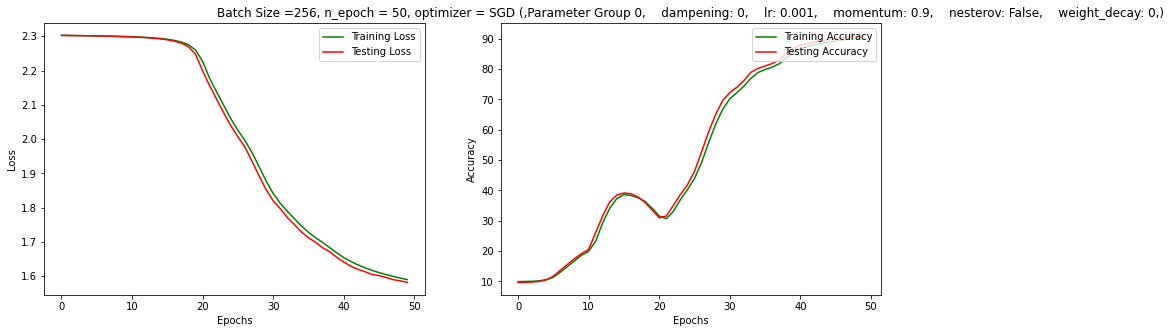

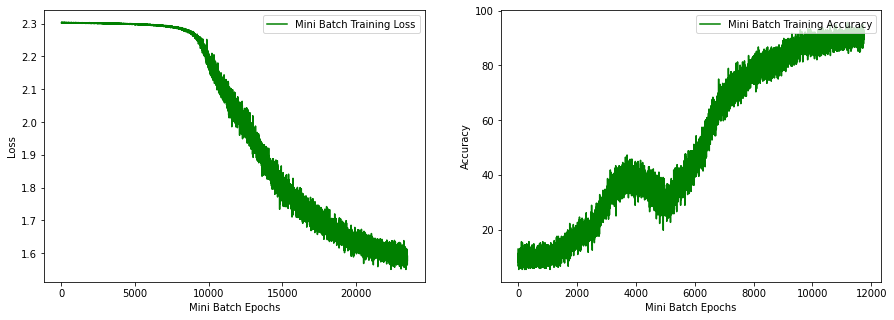

In [ ]:
batch_size = 256
learning_rate = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
pl = Pipeline(LeNet)

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
# optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch)

## Problem in using SGD so we can either increase the number of epoch by 100 or 1000 times OR change to mini batch OR use Adam

Refer: https://datascience.stackexchange.com/questions/19578/why-my-training-and-validation-loss-is-not-changing

Training using GPU: True
Batch Size : 32, Learning Rate : 0.5



Batch Size =32, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.5,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


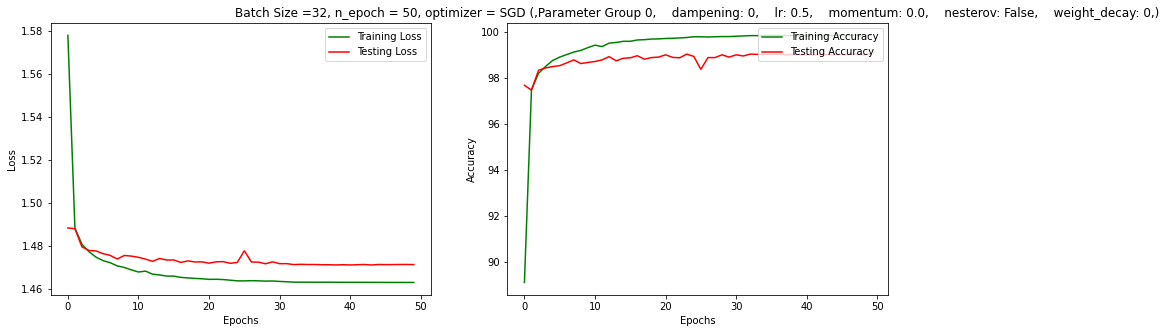

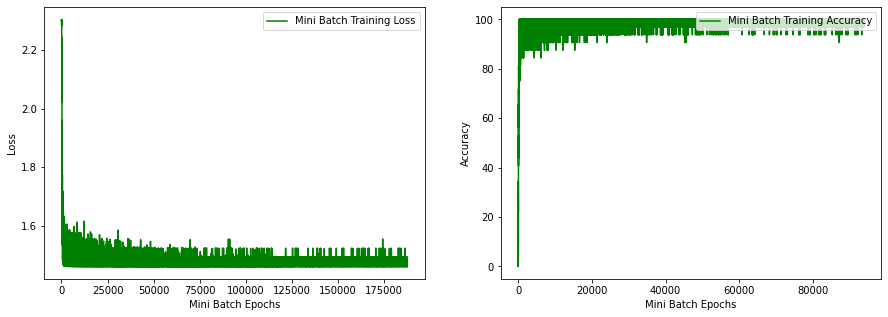

Training using GPU: True
Batch Size : 32, Learning Rate : 0.2



Batch Size =32, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.2,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


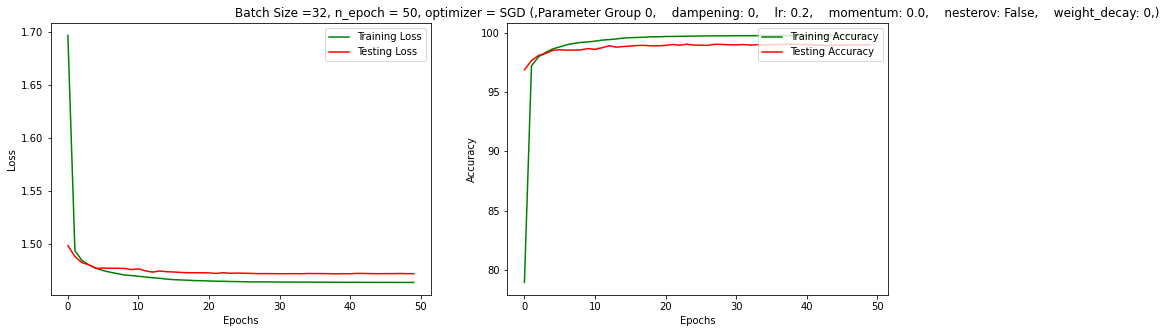

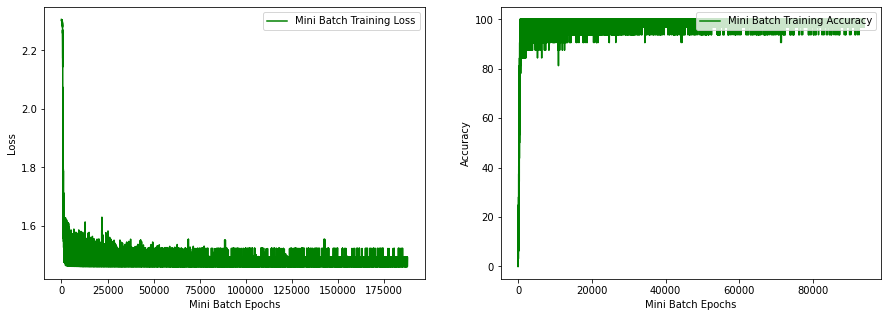

Training using GPU: True
Batch Size : 32, Learning Rate : 0.1



Batch Size =32, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.1,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


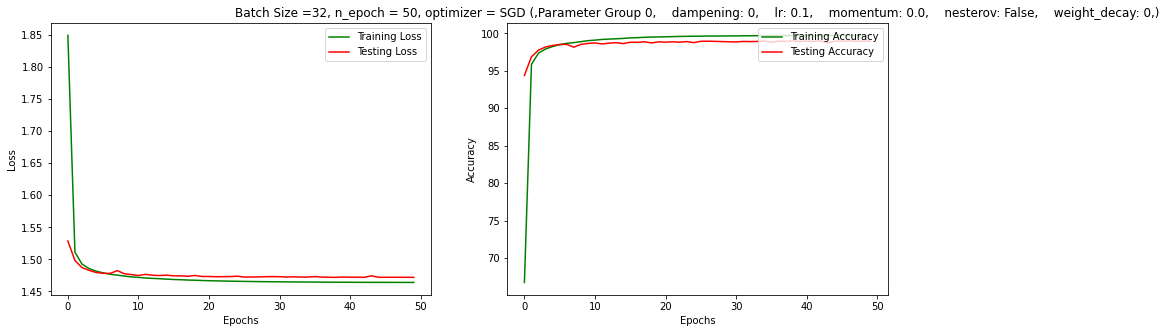

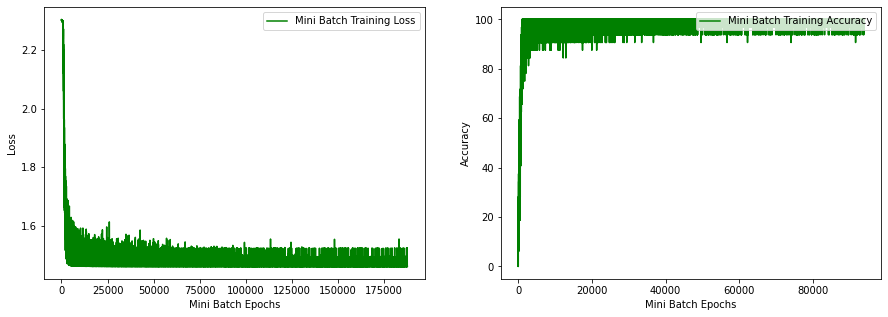

Training using GPU: True
Batch Size : 32, Learning Rate : 0.05



Batch Size =32, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.05,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


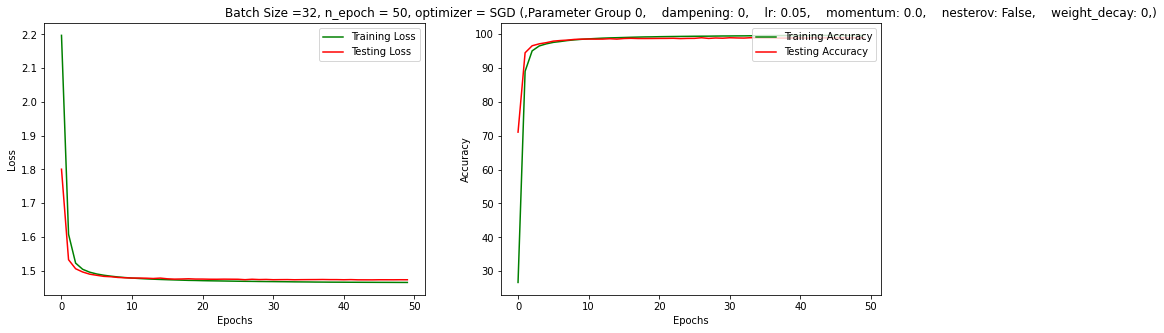

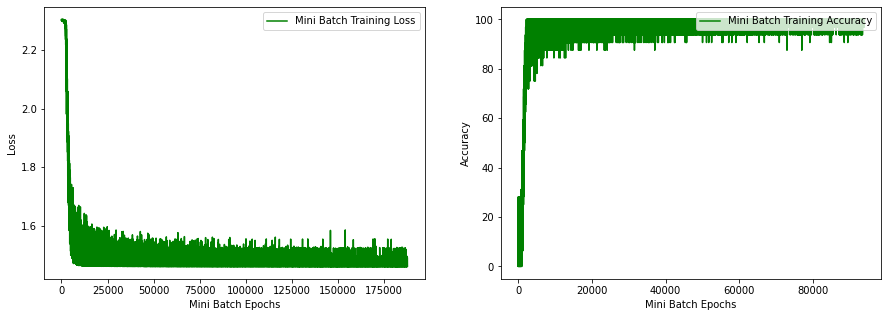

Training using GPU: True
Batch Size : 32, Learning Rate : 0.025



Batch Size =32, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.025,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


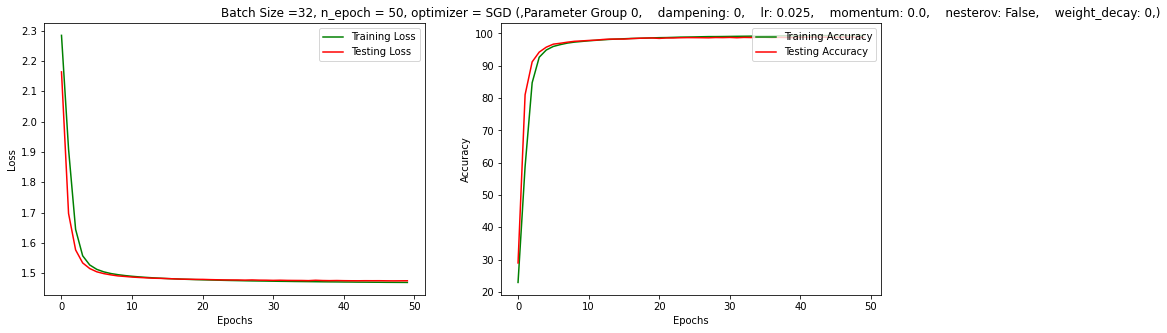

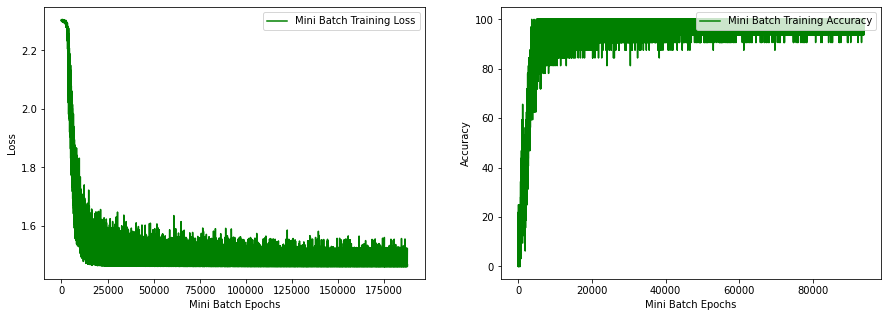

Training using GPU: True
Batch Size : 64, Learning Rate : 0.5



Batch Size =64, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.5,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


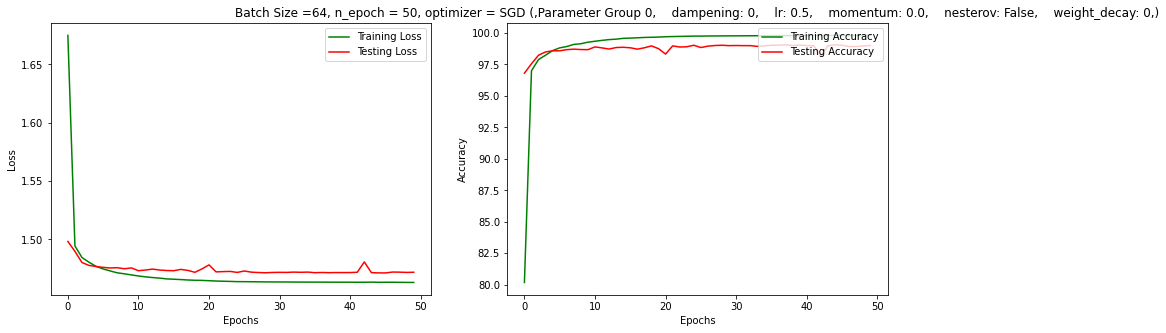

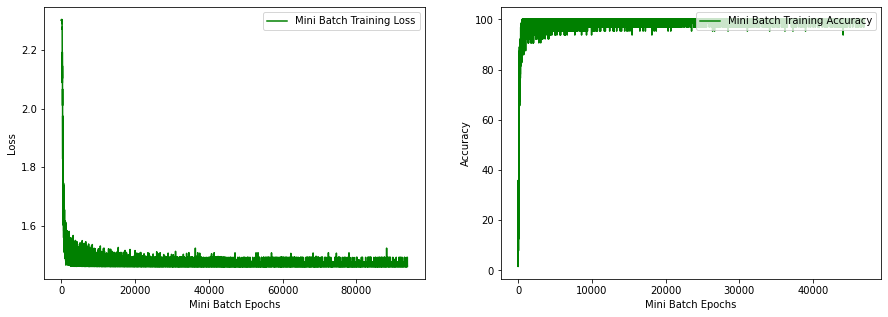

Training using GPU: True
Batch Size : 64, Learning Rate : 0.2



Batch Size =64, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.2,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


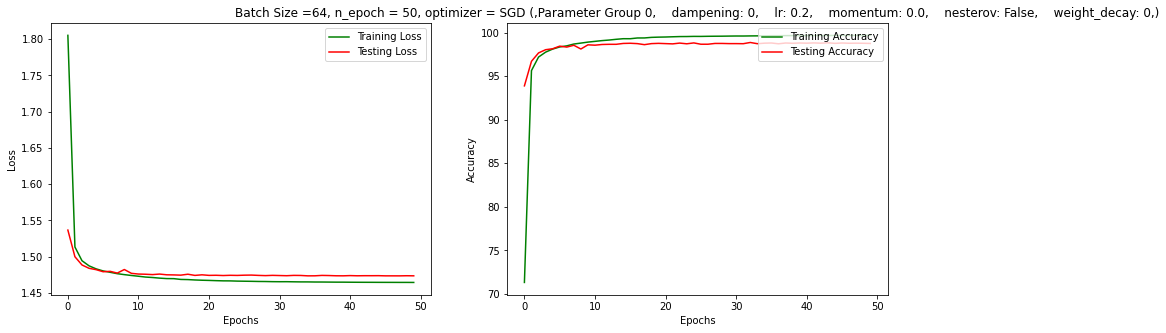

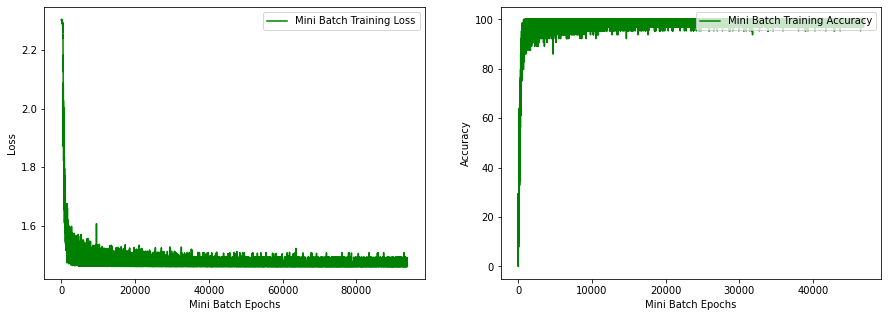

Training using GPU: True
Batch Size : 64, Learning Rate : 0.1



Batch Size =64, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.1,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


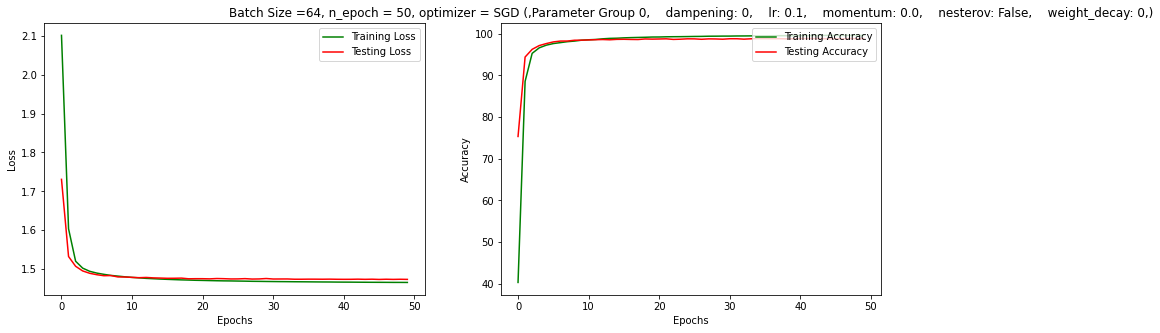

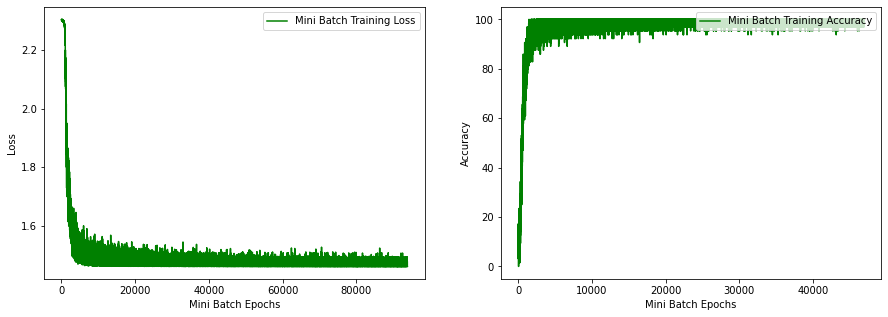

Training using GPU: True
Batch Size : 64, Learning Rate : 0.05



Batch Size =64, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.05,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


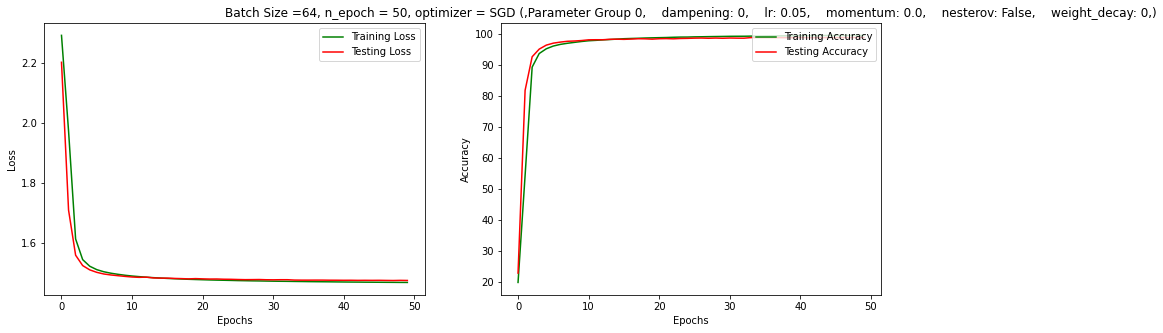

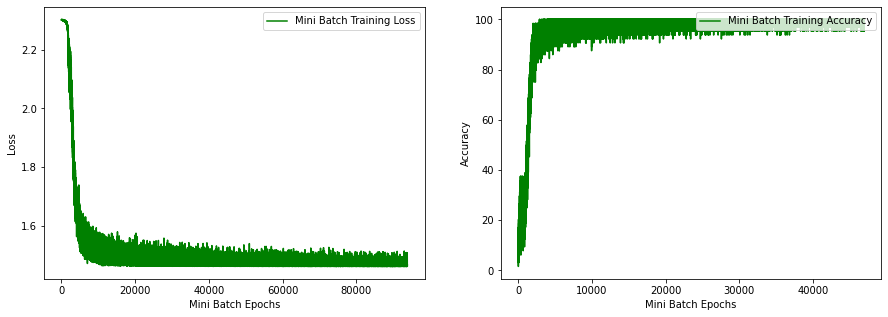

Training using GPU: True
Batch Size : 64, Learning Rate : 0.025



Batch Size =64, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.025,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


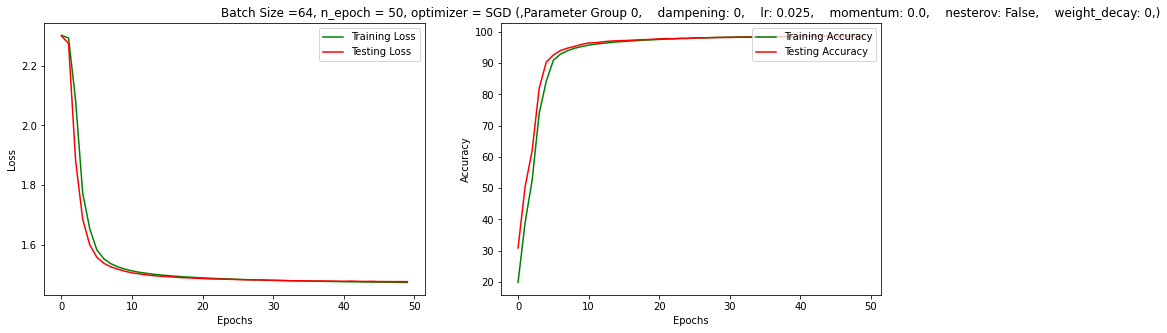

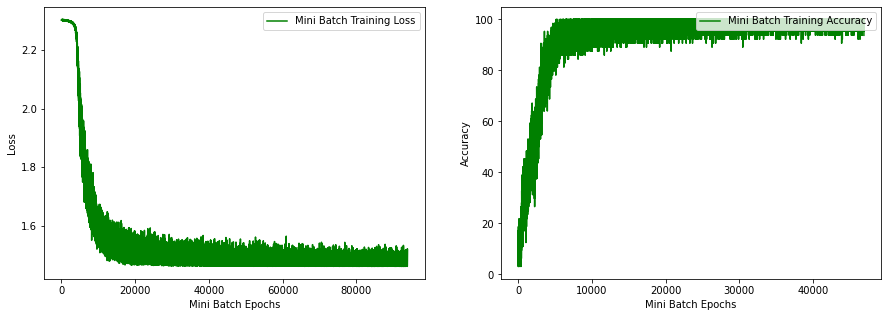

Training using GPU: True
Batch Size : 128, Learning Rate : 0.5



Batch Size =128, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.5,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


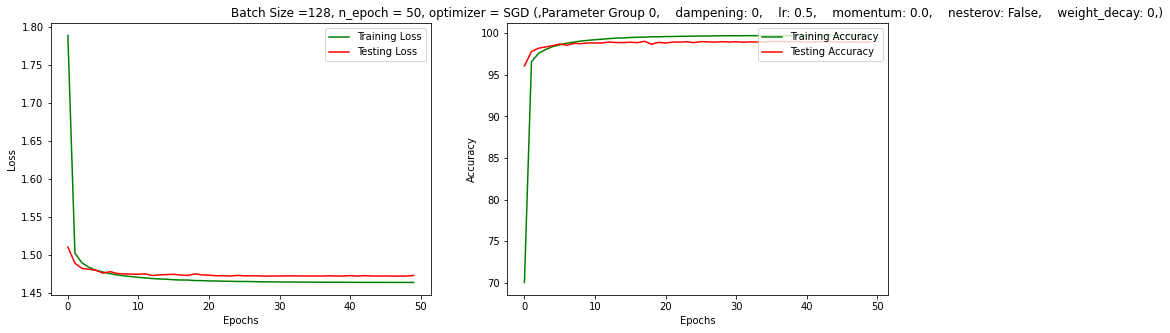

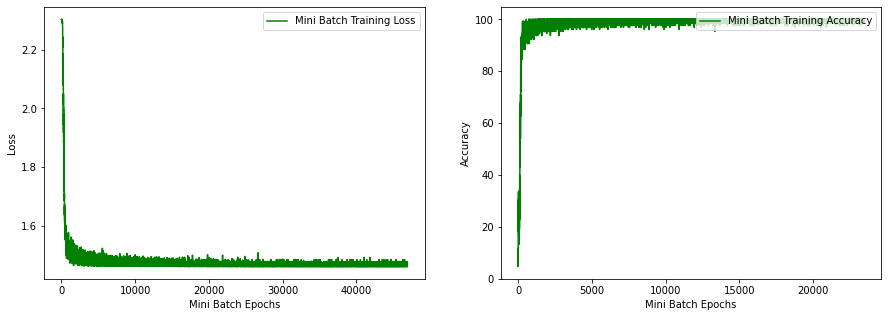

Training using GPU: True
Batch Size : 128, Learning Rate : 0.2



Batch Size =128, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.2,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


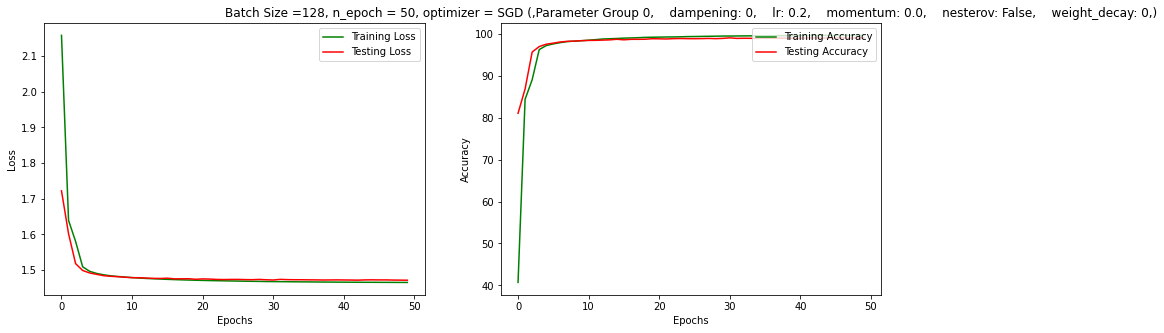

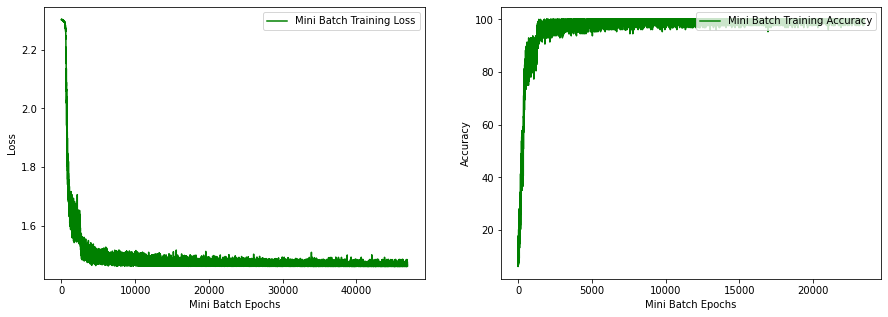

Training using GPU: True
Batch Size : 128, Learning Rate : 0.1



Batch Size =128, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.1,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


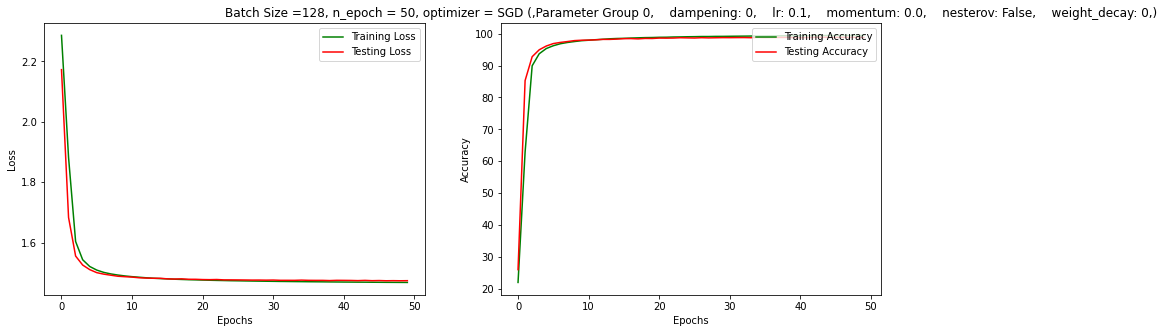

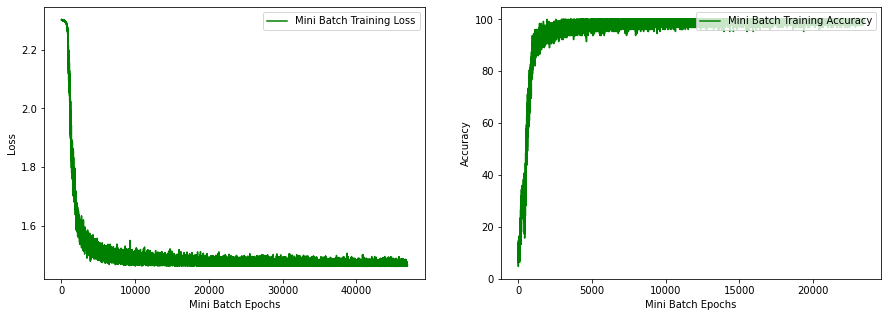

Training using GPU: True
Batch Size : 128, Learning Rate : 0.05



Batch Size =128, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.05,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


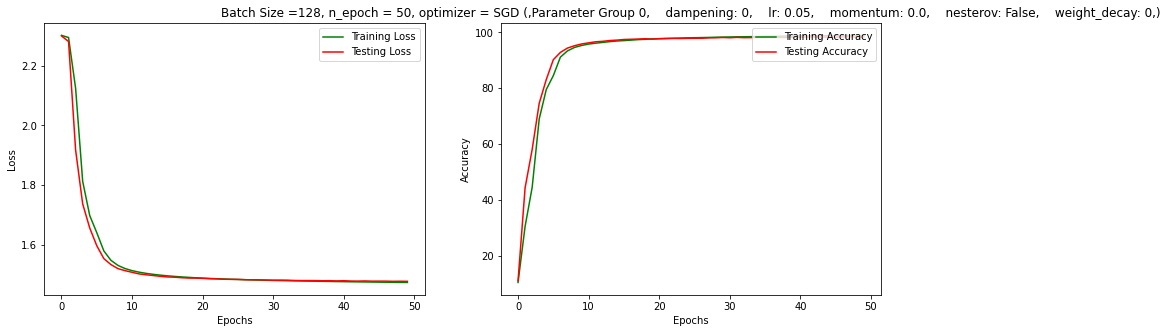

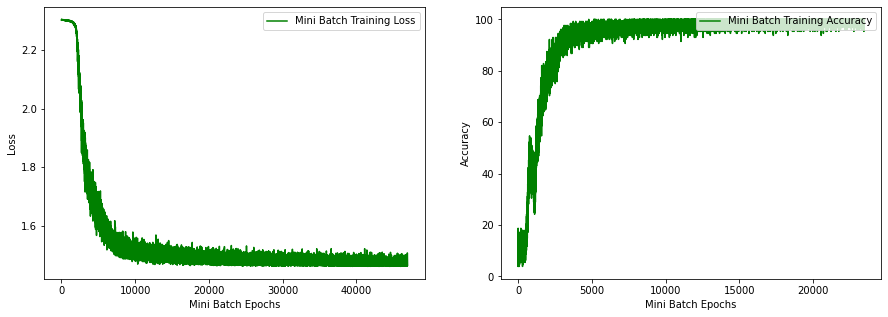

Training using GPU: True
Batch Size : 128, Learning Rate : 0.025



Batch Size =128, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.025,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


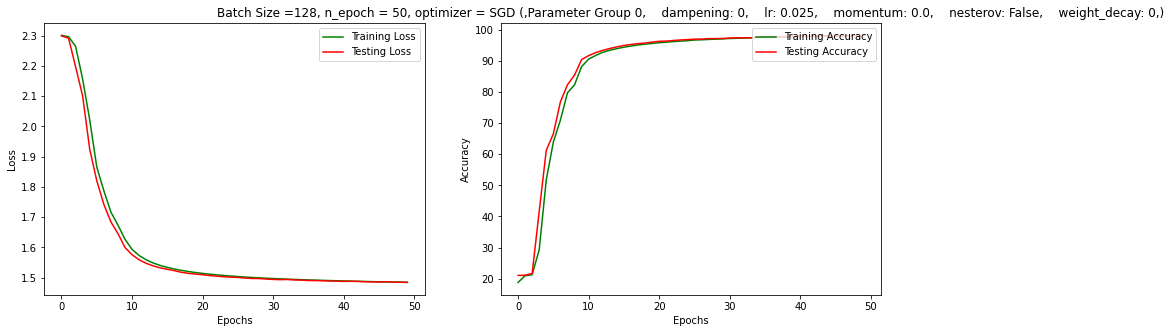

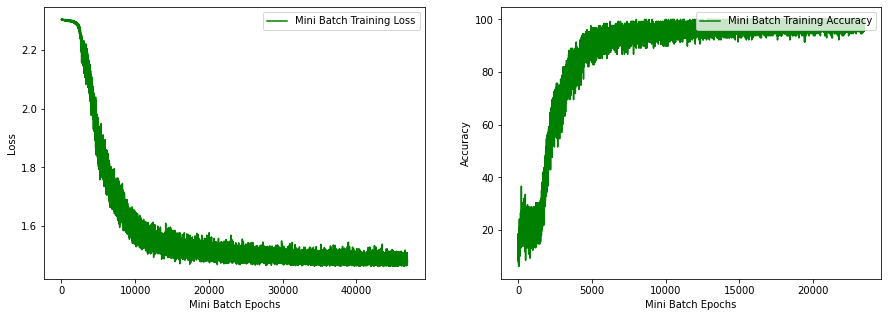

Training using GPU: True
Batch Size : 256, Learning Rate : 0.5



Batch Size =256, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.5,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


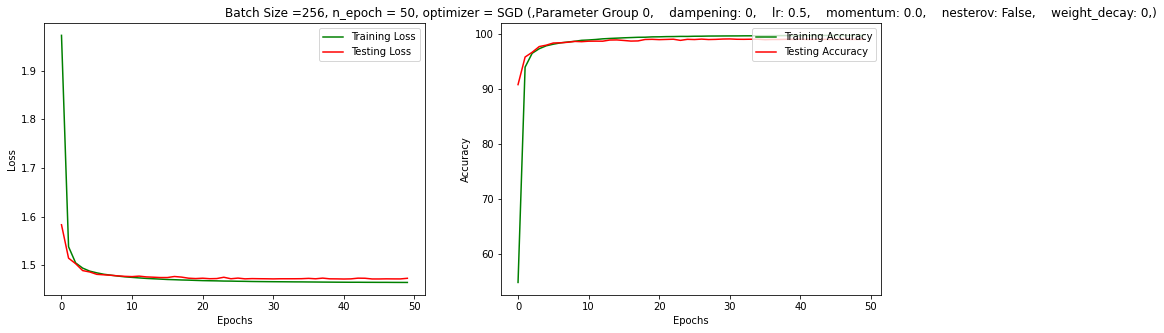

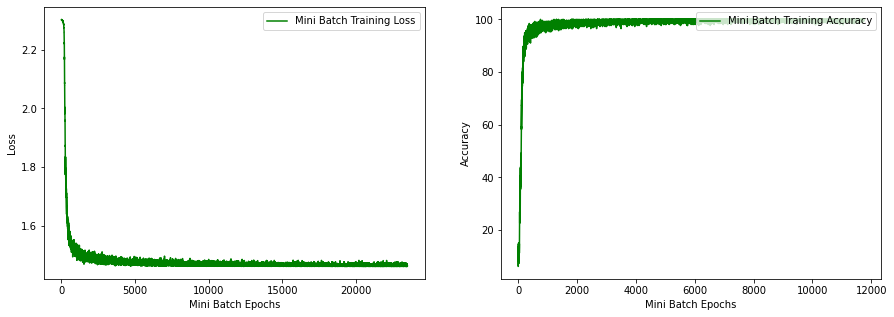

Training using GPU: True
Batch Size : 256, Learning Rate : 0.2



Batch Size =256, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.2,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


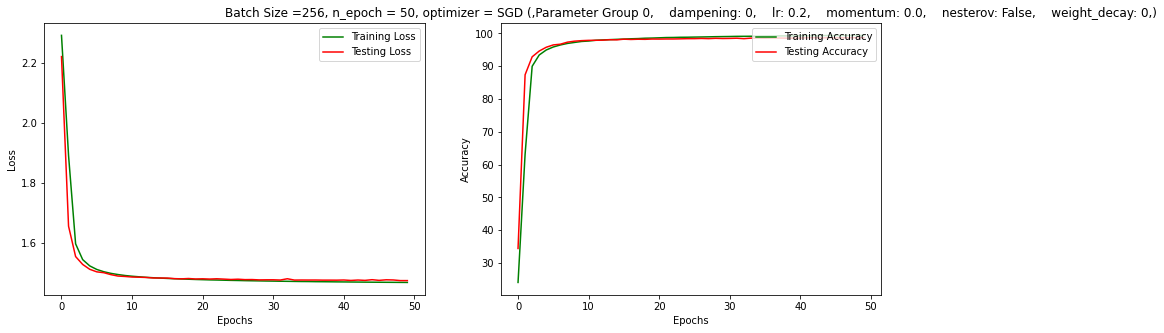

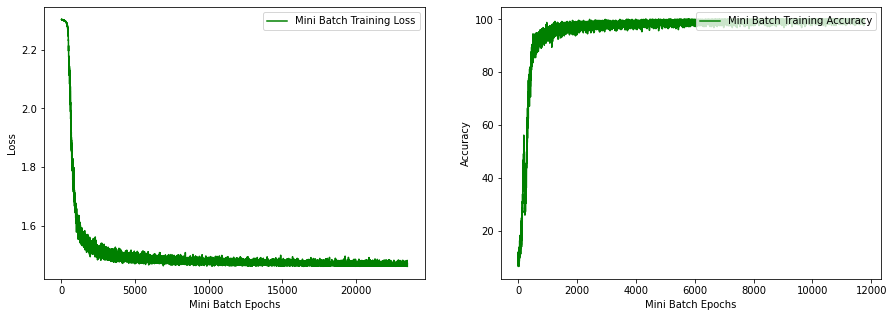

Training using GPU: True
Batch Size : 256, Learning Rate : 0.1



Batch Size =256, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.1,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


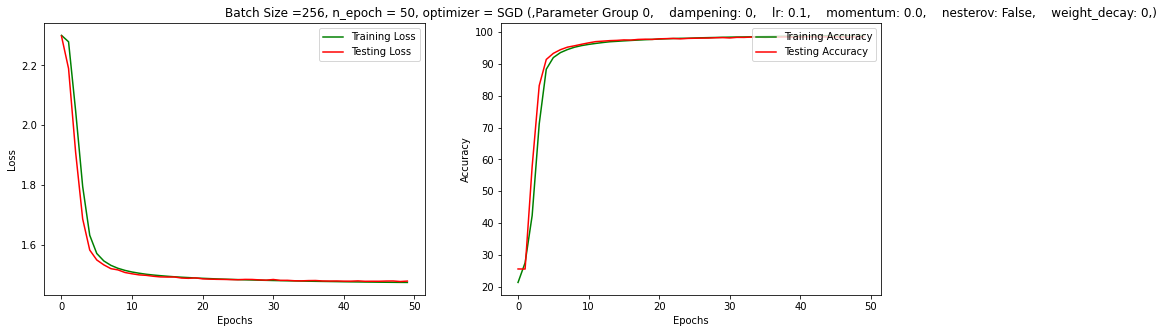

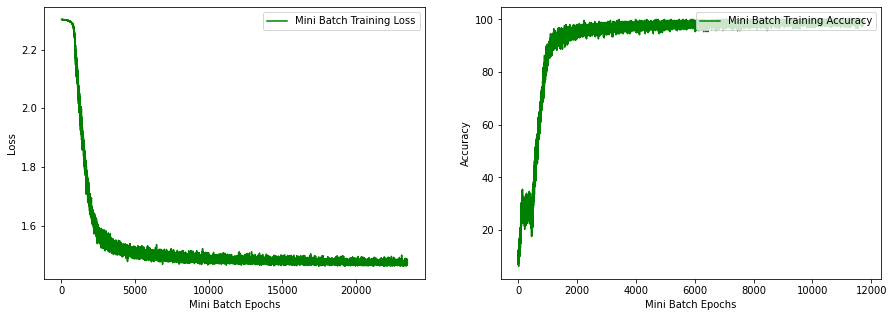

Training using GPU: True
Batch Size : 256, Learning Rate : 0.05



Batch Size =256, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.05,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


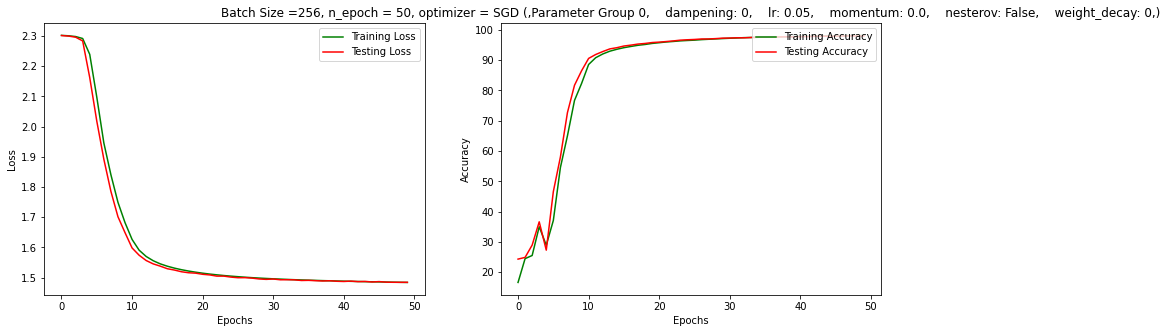

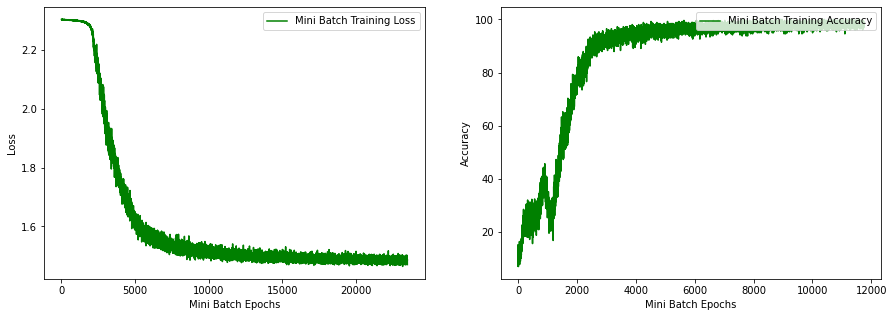

Training using GPU: True
Batch Size : 256, Learning Rate : 0.025



Batch Size =256, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.025,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


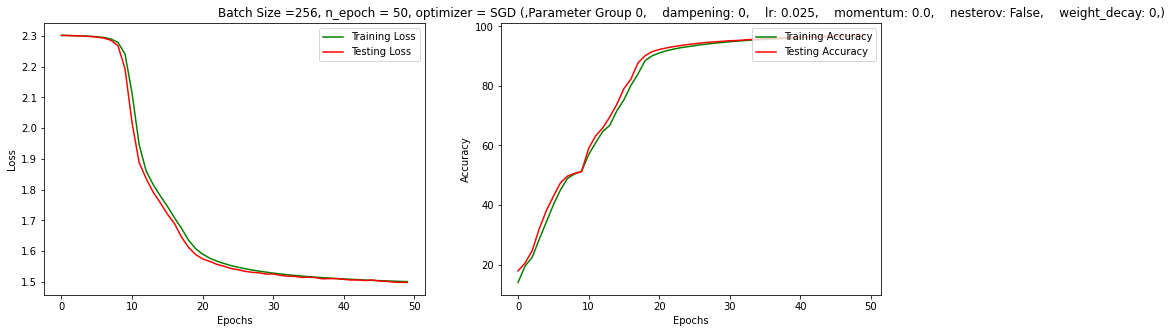

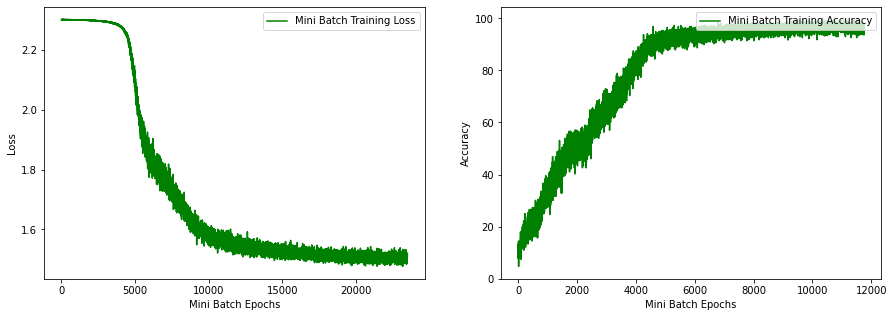

Training using GPU: True
Batch Size : 1024, Learning Rate : 0.5



Batch Size =1024, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.5,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


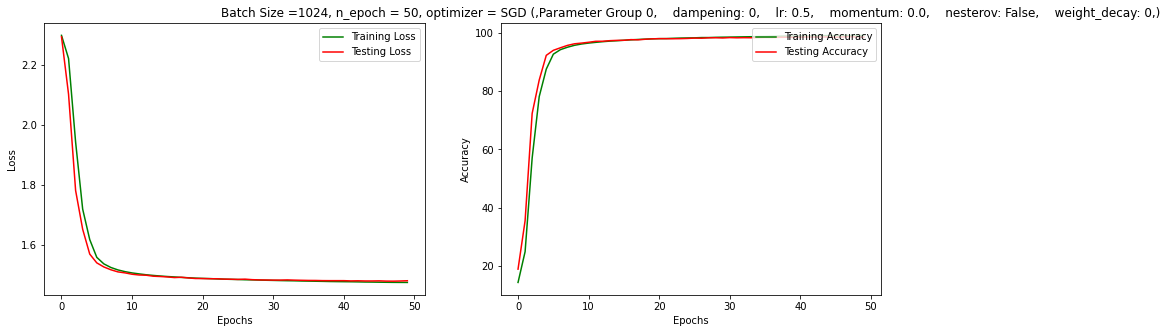

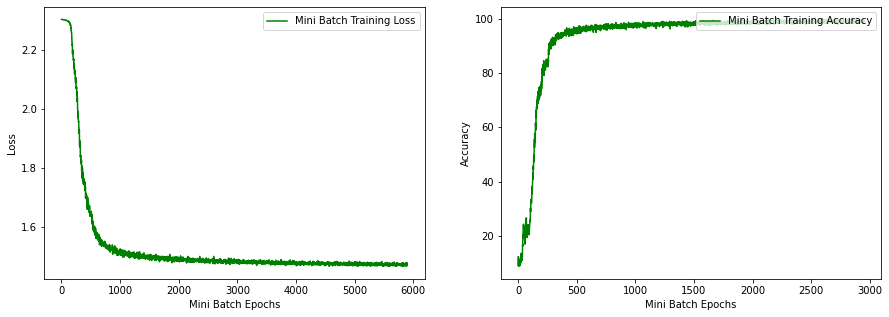

Training using GPU: True
Batch Size : 1024, Learning Rate : 0.2



Batch Size =1024, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.2,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


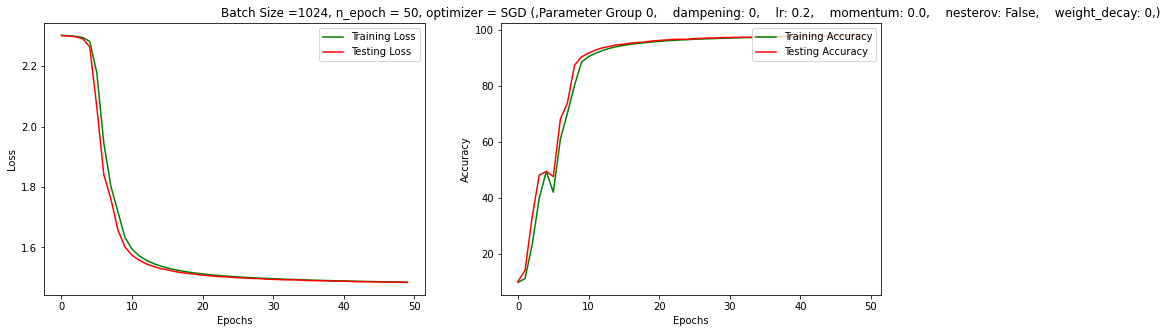

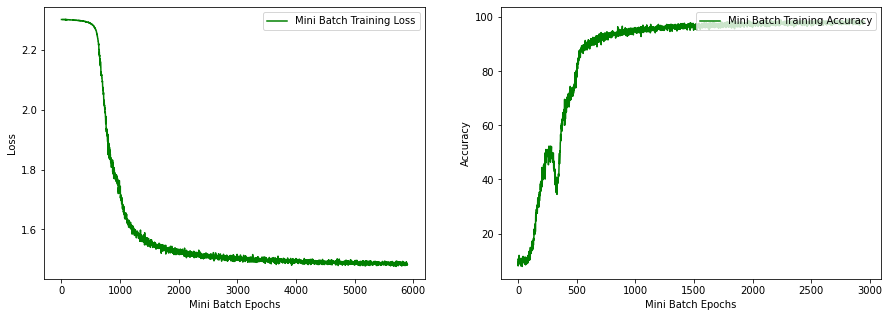

Training using GPU: True
Batch Size : 1024, Learning Rate : 0.1



Batch Size =1024, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.1,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


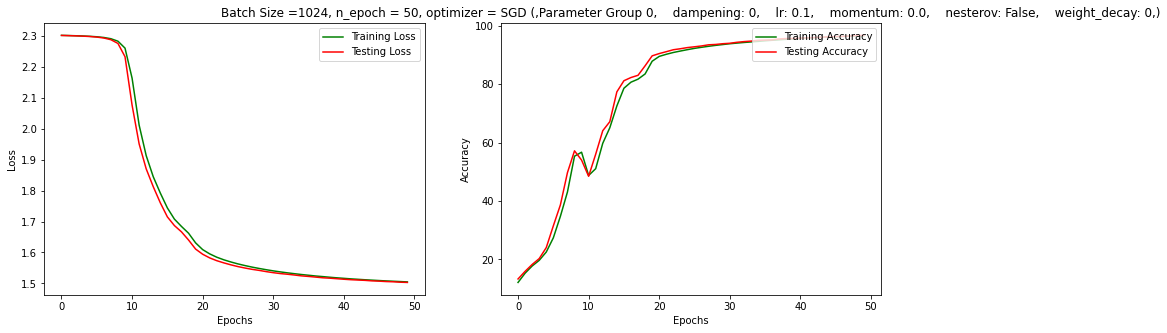

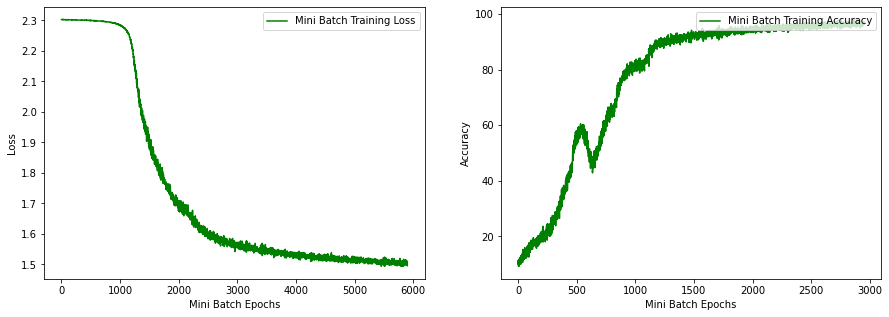

Training using GPU: True
Batch Size : 1024, Learning Rate : 0.05



Batch Size =1024, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.05,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


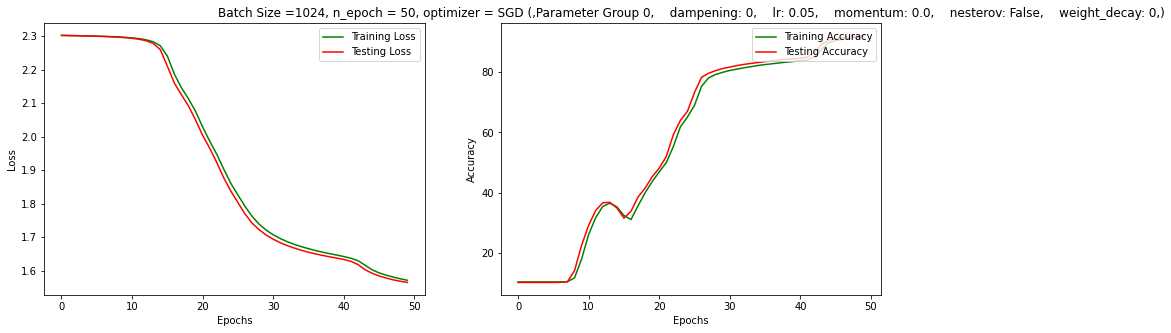

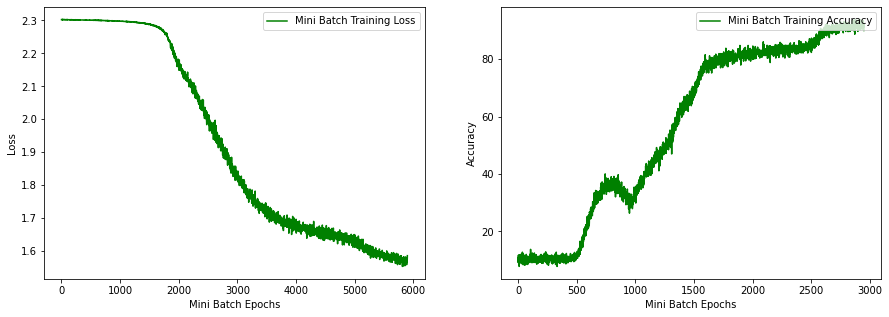

Training using GPU: True
Batch Size : 1024, Learning Rate : 0.025



Batch Size =1024, n_epoch = 50, optimizer = SGD (,Parameter Group 0,    dampening: 0,    lr: 0.025,    momentum: 0.0,    nesterov: False,    weight_decay: 0,)


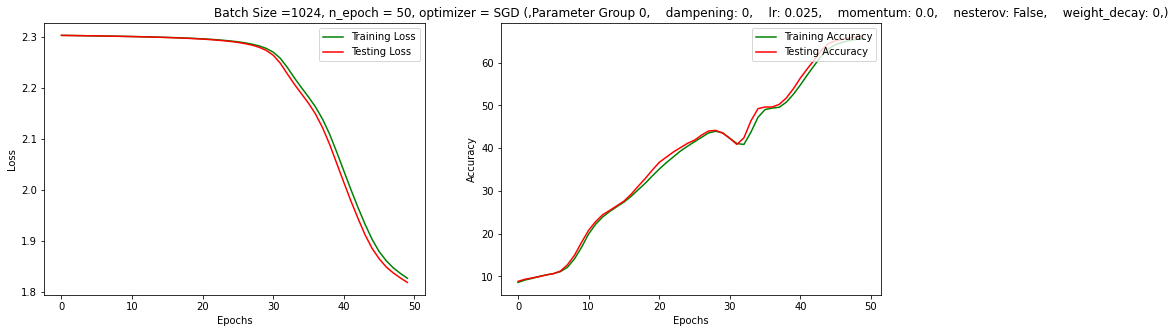

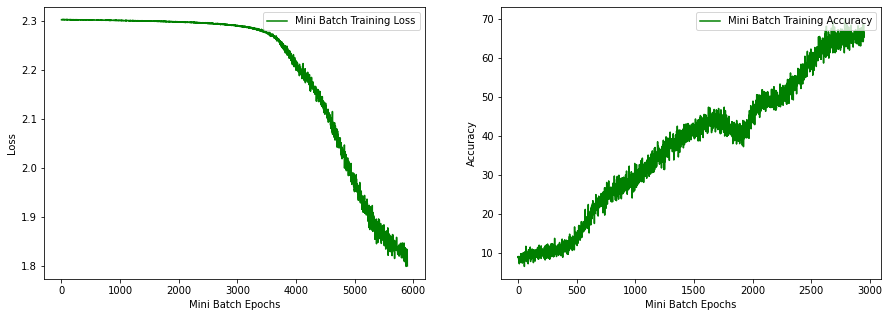

In [ ]:
# using SGD with mini batch

LR_list = [0.5,0.2,0.1,0.05,0.025] # learning rate list
BS_list = [32,64,128,256,1024] # batch size list

for batch_size in tqdm(BS_list):
  for learning_rate in tqdm(LR_list):
    momentum = 0.0

    criterion = nn.CrossEntropyLoss()
    pl = Pipeline(LeNet)

    trainloader,testloader = pl.load_data(batch_size)

    using_gpu = torch.cuda.is_available()
    if using_gpu:
        pl.model = pl.model.cuda()
        criterion = criterion.cuda()
    print("Training using GPU:",using_gpu)

    optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
    # optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)
    print(f"Batch Size : {batch_size}, Learning Rate : {learning_rate}")
    n_epoch = 50
    pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch,False)

## 6.a

* Observe that as we decrease the batch size the final accuracy reached increase as due to getting more training events
* Observe that as the batch size increases the mini batch learning curve becomes more smooth

## 6.b Observations

### For a specific Batch Size -

* We observe that as we decrease the Learning rate it takes longer and longer to reach the same level of loss ( or accuracy )
* We observe that for larger learning rates the loss ( or accuracy) curve ( mainly see the mini batch curve ) is much smoother( less varying ) see for eg. 0.5 and 0.05.
* We observe that there are less sudden changes in the accuracy ( loss ) curve ( mainly tarining epoch curve ) this maybe due to small learning rate may get go through small local minima which is not global minima whereas large learning rate may jump over it
* **So for this problem it seems best to have large enough learning rate at the start and slowly reduce it as we reach a local minima as to reach even less loss which is only possible if learning rate is small enough to allow the parameters to reach optimal parameter more accurately**

# Varying Learning rate along with epoch

Training using GPU: True


Epoch 1/50 : Training loss: 2.3015 | Training Accuracy: 10.79 | Testing loss: 2.2999 | Testing Accuracy: 22.51 
Epoch 2/50 : Training loss: 2.2961 | Training Accuracy: 35.33 | Testing loss: 2.2886 | Testing Accuracy: 38.20 
Epoch 3/50 : Training loss: 2.1893 | Training Accuracy: 39.73 | Testing loss: 1.9948 | Testing Accuracy: 50.26 
Epoch 4/50 : Training loss: 1.8565 | Training Accuracy: 65.47 | Testing loss: 1.7532 | Testing Accuracy: 75.26 
Epoch 5/50 : Training loss: 1.6972 | Training Accuracy: 80.76 | Testing loss: 1.6378 | Testing Accuracy: 87.19 
Epoch 6/50 : Training loss: 1.6037 | Training Accuracy: 89.88 | Testing loss: 1.5704 | Testing Accuracy: 92.13 
Epoch 7/50 : Training loss: 1.5626 | Training Accuracy: 92.43 | Testing loss: 1.5425 | Testing Accuracy: 93.70 
Epoch 8/50 : Training loss: 1.5419 | Training Accuracy: 93.82 | Testing loss: 1.5282 | Testing Accuracy: 94.64 
Epoch 9/50 : Training loss: 1.5287 | Training Accuracy: 94.77 | Testing loss: 1.5187 | Testing Accuracy:

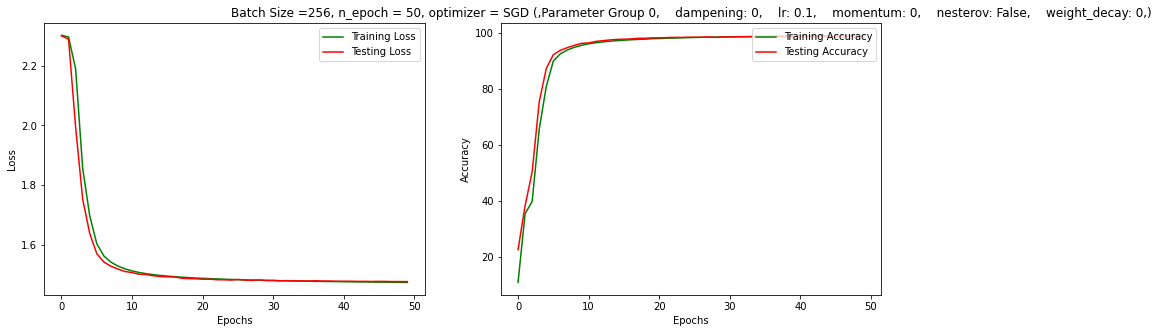

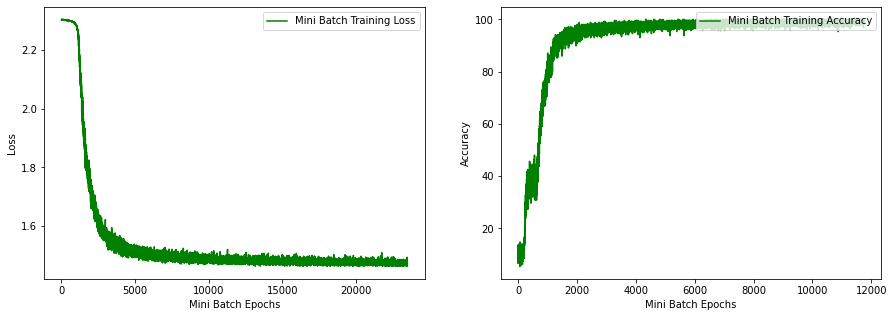

In [ ]:
# Varying LR

batch_size = 256
learning_rate = 1e-1
momentum = 0

criterion = nn.CrossEntropyLoss()
pl = Pipeline(LeNet)
pl.LR_decay = True

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
# optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch)

Training using GPU: True


Epoch 1/50 : Training loss: 2.3013 | Training Accuracy: 10.04 | Testing loss: 2.2994 | Testing Accuracy: 9.81 
Epoch 2/50 : Training loss: 2.2945 | Training Accuracy: 27.27 | Testing loss: 2.2820 | Testing Accuracy: 46.39 
Epoch 3/50 : Training loss: 2.1526 | Training Accuracy: 37.58 | Testing loss: 1.9833 | Testing Accuracy: 51.12 
Epoch 4/50 : Training loss: 1.8313 | Training Accuracy: 69.69 | Testing loss: 1.7140 | Testing Accuracy: 79.90 
Epoch 5/50 : Training loss: 1.6701 | Training Accuracy: 84.01 | Testing loss: 1.6171 | Testing Accuracy: 88.56 
Epoch 6/50 : Training loss: 1.5982 | Training Accuracy: 89.62 | Testing loss: 1.5712 | Testing Accuracy: 91.45 
Epoch 7/50 : Training loss: 1.5646 | Training Accuracy: 91.97 | Testing loss: 1.5504 | Testing Accuracy: 93.05 
Epoch 8/50 : Training loss: 1.5445 | Training Accuracy: 93.47 | Testing loss: 1.5338 | Testing Accuracy: 94.03 
Epoch 9/50 : Training loss: 1.5312 | Training Accuracy: 94.43 | Testing loss: 1.5244 | Testing Accuracy: 

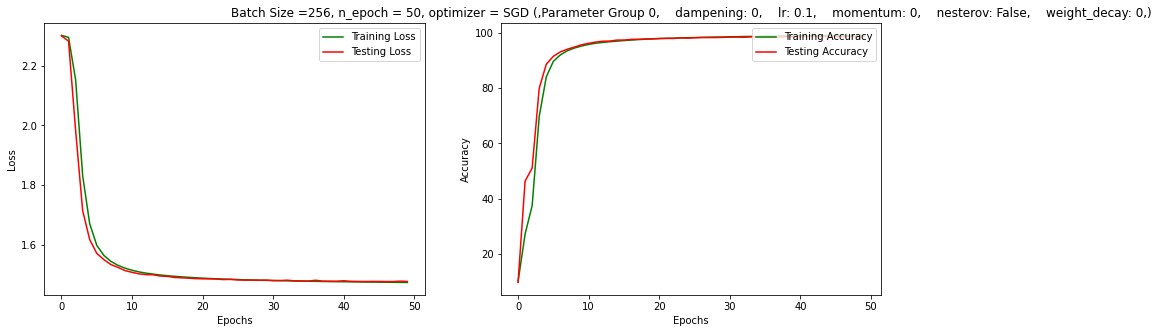

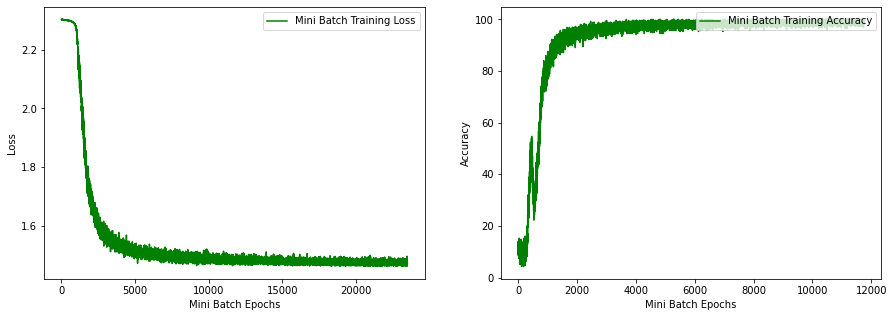

In [ ]:
# Constant LR with max value 

batch_size = 256
learning_rate = 1e-1
momentum = 0

criterion = nn.CrossEntropyLoss()
pl = Pipeline(LeNet)

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
# optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch)

Training using GPU: True


Epoch 1/50 : Training loss: 2.3023 | Training Accuracy: 11.19 | Testing loss: 2.3023 | Testing Accuracy: 11.31 
Epoch 2/50 : Training loss: 2.3022 | Training Accuracy: 11.33 | Testing loss: 2.3023 | Testing Accuracy: 11.54 
Epoch 3/50 : Training loss: 2.3022 | Training Accuracy: 11.45 | Testing loss: 2.3022 | Testing Accuracy: 11.71 
Epoch 4/50 : Training loss: 2.3022 | Training Accuracy: 11.58 | Testing loss: 2.3022 | Testing Accuracy: 11.84 
Epoch 5/50 : Training loss: 2.3021 | Training Accuracy: 11.73 | Testing loss: 2.3021 | Testing Accuracy: 12.02 
Epoch 6/50 : Training loss: 2.3021 | Training Accuracy: 11.87 | Testing loss: 2.3022 | Testing Accuracy: 12.22 
Epoch 7/50 : Training loss: 2.3021 | Training Accuracy: 12.00 | Testing loss: 2.3021 | Testing Accuracy: 12.36 
Epoch 8/50 : Training loss: 2.3020 | Training Accuracy: 12.17 | Testing loss: 2.3021 | Testing Accuracy: 12.49 
Epoch 9/50 : Training loss: 2.3020 | Training Accuracy: 12.32 | Testing loss: 2.3021 | Testing Accuracy:

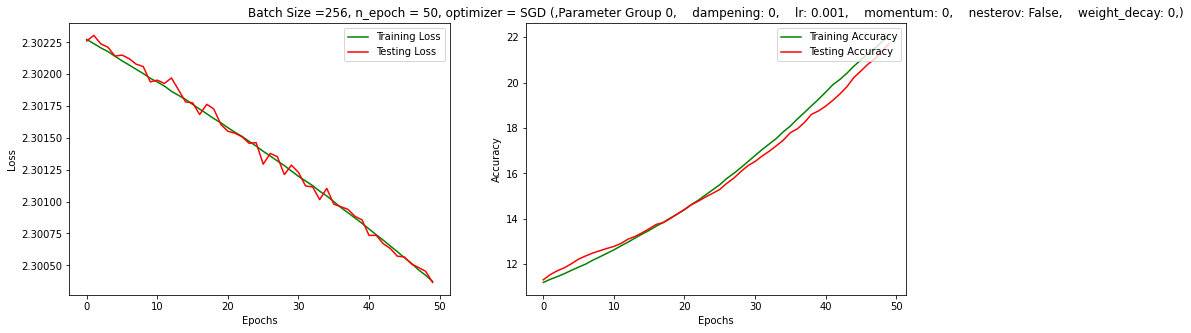

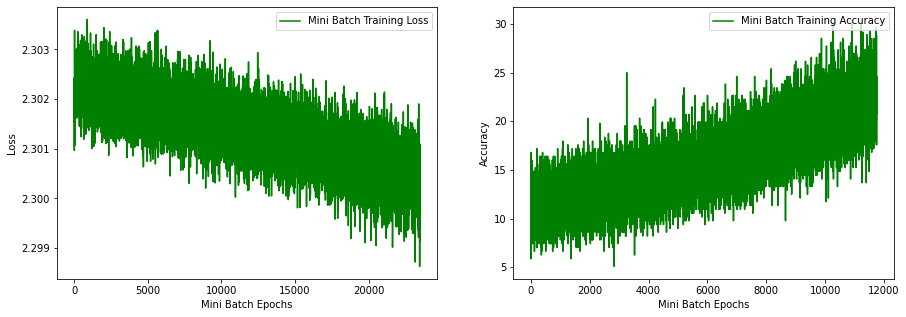

In [ ]:
# Constant LR with min value 

batch_size = 256
learning_rate = 1e-3
momentum = 0

criterion = nn.CrossEntropyLoss()
pl = Pipeline(LeNet)

trainloader,testloader = pl.load_data(batch_size)

using_gpu = torch.cuda.is_available()
if using_gpu:
    pl.model = pl.model.cuda()
    criterion = criterion.cuda()
print("Training using GPU:",using_gpu)

optimizer_sgd = optim.SGD(pl.model.parameters(),lr=learning_rate,momentum=momentum)
# optimizer_adam = optim.Adam(pl.model.parameters(),lr=learning_rate)

n_epoch = 50
pl.train_mini_batch(trainloader,testloader,criterion,optimizer_sgd,n_epoch)

## 6.c Observations
* Observe that when er use the min of learning rate the convergens will take more number of epoch as the step size towards the optima are small
* When we use the varying ( here we implemented linear varying ) learning rate we reach the optima value with less sudden changes compared to the max learning rate, hence this methods seems more stable and also as fast.